# Summary of work

This notebook explores how closely unique molecular structures within each group resemble eachother using the Jaccard or Tanimoto index. This should help determine which compound groups are most suitable for identification of new compounds via similarity.

# Load libraries and data

In [1]:
#from rdkit import Chem
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import percentileofscore
from scipy.spatial.distance import cdist
from sklearn.preprocessing import scale
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from matchms.similarity import FingerprintSimilarity
from matchms.filtering import add_fingerprint
import matplotlib as mpl
from mass_differences.processing import get_ids_for_unique_inchikeys
import csv

RDKit WARNING: [08:45:35] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
# Specify directories
data_dir = "/mnt/scratch/ding013/MS2ChemClass/hooft_data/datasets/ALL_GNPS_210409_positive/"
embedding_path='/mnt/scratch/ding013/MS2ChemClass/embedding_arrays_for_classification/X_spectral_embeddings.csv'
classification_path='/mnt/LTR_userdata/hooft001/mass_spectral_embeddings/classifications/ALL_GNPS_210409_positive/'
fingerprint_dir = "/mnt/scratch/ding013/MS2ChemClass/fingerprint/"
plot_dir = '/mnt/scratch/ding013/MS2ChemClass/barplot_accuracy_groupsize_jaccard2/'

# Define functions for jaccard similarity
def jaccard_similarity_for_groups(metadata_df, var, spectra, min_class_size=50):
    class_count = metadata_df[var].value_counts(ascending=False)
    selected_classes = class_count[class_count>=min_class_size]
    similarity_measure = FingerprintSimilarity(similarity_measure="jaccard")
    print(len(selected_classes), "classes exceed minimum class size")

    jaccard_array = []
    for group in selected_classes.index:
        #print(group)
        bool_index = (metadata_df[var] == group) & (metadata_df["inchi"] != "")
        selection = metadata_df[bool_index]
        spectra_selection = [spectra[i] for i in selection.index]
        similarity_matrix = similarity_measure.matrix(spectra_selection, spectra_selection)
        similarity_triangle = similarity_matrix[np.triu_indices(n=len(selection))]
        jaccard_array += [similarity_triangle]
    return selected_classes, jaccard_array


def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center", fontsize = 8) 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [3]:
# Define function for barplot
def ordering_accuracy_groupsize_similarity(accuracy_dict, internal_class_percentile_scores):
    # Order accuracy lists
    accuracy_desending_index = [i[0] for i in sorted(enumerate(accuracy_dict['accuracy']), key=lambda k: k[1], reverse=True)]
    accuracy_desending = [accuracy_dict['accuracy'][i] for i in accuracy_desending_index]
    label_orderedby_accuracy = [accuracy_dict['labels'][i] for i in accuracy_desending_index]
    groupsize = [(accuracy_dict['group_size'][i]) for i in range(len(accuracy_dict['group_size']))]
    groupsize_orderedby_accuracy = [groupsize[i] for i in accuracy_desending_index]
    print(str(len(groupsize))+' groups involved.')

    # Connect jaccard values to accuracies
    jaccard_labels = list(internal_class_percentile_scores.index)
    jaccard_values = list(internal_class_percentile_scores.values)

    #for j in jaccard_labels:
    #    if j not in label_orderedby_accuracy:
    #        print(j+ ': '+ str(jaccard_values[jaccard_labels.index(j)]))
    new_jaccard_values=[]
    for i,v in enumerate(label_orderedby_accuracy):
        if v not in jaccard_labels:
            new_jaccard_values.append(0)
            print('Lack: ' + v+' size = '+ str(groupsize_orderedby_accuracy[i]))
        else:
            jcd_value = jaccard_values[jaccard_labels.index(v)]
            new_jaccard_values.append(jcd_value)
    return label_orderedby_accuracy,accuracy_desending,groupsize_orderedby_accuracy,new_jaccard_values


def ordering_accuracy_groupsize_similarity_by_hierarchical_class(label_orderedby_accuracy, hierarchical_labels, accuracy_list,groupsize_list,jaccard_values):
    #hierarchical_labels = [(npc_class_belong[v]+' <<< '+v) for v in label_orderedby_accuracy]
    label_index = [i[0] for i in sorted(enumerate(hierarchical_labels), key=lambda k: k[1])]
    ordered_labels = [hierarchical_labels[i] for i in label_index]
    ordered_accuracy_list = [accuracy_list[i] for i in label_index]
    ordered_groupsize_list = [groupsize_list[i] for i in label_index]
    ordered_jaccard_list = [jaccard_values[i] for i in label_index]
    return ordered_labels,ordered_accuracy_list,ordered_groupsize_list,ordered_jaccard_list
    
    
def making_three_barplots_in_one_figure(accuracy_desending,label_orderedby_accuracy,groupsize_orderedby_accuracy,new_jaccard_values,save_path,data_type='cf_class_lda',plot_size=(10,15), left_align=False):
    # Plot group size vs. accuracy vs. Jaccard similarity
    f, axes = plt.subplots(1, 3, figsize=plot_size, gridspec_kw={'width_ratios': [1, 1, 1]})
    f.subplots_adjust(hspace=0.025, wspace=0.05)

    fig1 = sns.barplot(x = [i*100 for i in accuracy_desending], y = label_orderedby_accuracy, ax = axes[0],palette=mpl.cm.viridis(accuracy_desending))
    fig1.set_title('Accuracy in %s' % data_type, fontsize=16)
    fig1.set_xlabel("Predicted accuracy per label")
    if left_align == True:
        #fig1.set_yticks(np.array(range(len(label_orderedby_accuracy))) + 0.5)
        fig1.set_yticklabels(label_orderedby_accuracy, ha='left')
        plt.draw()
        yax = fig1.get_yaxis()
        pad = max(T.label.get_window_extent().width for T in yax.majorTicks)
        yax.set_tick_params(pad=pad)
        plt.draw()
    show_values_on_bars(fig1, "h", 0.3)

    fig2 = sns.barplot(x = groupsize_orderedby_accuracy, y = label_orderedby_accuracy, ax = axes[1],palette=mpl.cm.viridis(np.array(groupsize_orderedby_accuracy)*.001))
    fig2.set_title("Group size", fontsize = 16)
    fig2.set_xlabel("Number of compounds in each label")
    #fig2.set_xlim(0,600)
    show_values_on_bars(fig2, "h", 6)
    fig2.set_yticklabels([]);

    fig3 = sns.barplot(x = new_jaccard_values, y = label_orderedby_accuracy, ax = axes[2],palette=mpl.cm.viridis(np.array(new_jaccard_values)*.01))
    fig3.set_xlabel('Percentage of compound pairs in group exceeding 0.6 Jaccard similarity')
    fig3.set_title("Internal Jaccard similarity", fontsize=16)
    show_values_on_bars(fig3, "h", 0.01)
    fig3.set_yticklabels([]);

    plt.savefig(save_path,dpi=300,bbox_inches='tight')


In [4]:
# Load original spectra file
spectra = pd.read_pickle(data_dir+"ALL_GNPS_210409_positive_cleaned_peaks_processed_s2v_only_annotated.pickle")
# spectrum_vectors = pd.read_csv(embedding_path, sep = "\t", header = None)

In [5]:
# Load the class predictions for each inchikey
inchikey_classifications = pd.read_csv(classification_path+"ALL_GNPS_210409_positive_processed_annotated_CF_NPC_classes.txt", sep = "\t")
inchikey_classifications.rename(columns = {"inchi_key": "inchikey"}, inplace = True) 

# Prep data

####### Add fingerprints to spectra to calculate Tanimoto distance later
for i, spectrum in enumerate(spectra):
    spectra[i] = add_fingerprint(spectra[i], fingerprint_type="daylight", nbits=2048)
pickle.dump(spectra, open(fingerprint_dir+"ALL_GNPS_210409_positive_cleaned_peaks_processed_s2v_fingerprint.pickle", "wb"))

In [6]:
# Load spectra with fingerprints
spectra = pickle.load(open(fingerprint_dir+"ALL_GNPS_210409_positive_cleaned_peaks_processed_s2v_fingerprint.pickle", "rb"))
# spectra = pickle.load(open(data_dir+"ALL_GNPS_210409_positive_cleaned_peaks_processed_s2v.pickle", "rb"))

In [7]:
# Get metadata; we retrieve the inchikey and source instrument for all spectra, and look up the predicted classes for the inchikey.
spectrum_id = []; inchikeys = []; inchi = []; instruments = []

for spec in spectra:
    inchikeys.append(spec.get("inchikey"))
    inchi.append(spec.get("inchi"))
    instruments.append(spec.get("instrument"))
    spectrum_id.append(spec.get("spectrum_id"))
spectrum_metadata = pd.DataFrame({"ID": spectrum_id, "inchikey":inchikeys, "inchi": inchi, "instrument": instruments})

# We drop all spectral records without inchikey and match the remaining records with npclassifier and classyfire compound class predictions
spectrum_metadata['spectrum_index'] = spectrum_metadata.index # Merging dataframes changes the row order, so we're saving the index now as a column to restore it after merging
spectrum_metadata = spectrum_metadata[spectrum_metadata["inchikey"] != ""]
spectrum_metadata = spectrum_metadata.merge(inchikey_classifications, how='left', on='inchikey', sort=False).sort_values(by="spectrum_index")

spectrum_metadata["planar_inchi"] = [key[:14] for key in spectrum_metadata["inchikey"]] # Add shortened planar inchikey to metadata
inchi_spectra = [spectra[i] for i in spectrum_metadata["spectrum_index"]] # Subset the spectra to only the spectra with inchikeys
print(len(inchi_spectra), "out of", len(spectra), "spectra are annotated with an Inchikey")
spectrum_metadata.reset_index(drop = True, inplace = True) # Match indices to inchi_spectra indices

# We retrieve the IDs of spectra with unique planar Inchikeys
unique_inchi = get_ids_for_unique_inchikeys(inchi_spectra)
print(f'{len(unique_inchi)} out of {len(inchi_spectra)} annotated spectra have a unique Inchikey')

# Quick check to see that the spectra and spectrum_metadata match up
print("Spectra and metadata match:", inchi_spectra[17000].get("spectrum_id") == spectrum_metadata["ID"][17000])

187152 out of 187152 spectra are annotated with an Inchikey
16360 out of 187152 annotated spectra have a unique Inchikey
Spectra and metadata match: True


In [8]:
del(spectra)

# Jaccard / Tanimoto distance
The Jaccard index, also known as the Jaccard similarity coefficient, is a statistic used for gauging the similarity and diversity of sample sets. It was developed by Paul Jaccard, originally giving the French name coefficient de communauté, and independently formulated again by T. Tanimoto. Thus, the Tanimoto index or Tanimoto coefficient are also used in some fields. 

## ClassyFire classes 

In [9]:
# Get Jaccard similarities
classes, jaccard_class = jaccard_similarity_for_groups(metadata_df = spectrum_metadata.iloc[unique_inchi], var="cf_class", 
                                                                    spectra = inchi_spectra, min_class_size=4)
# Which percentage of spectrum pairs has a similarity higher than the threshold value of 0.6?
internal_class_percentile_scores = 100-pd.Series([percentileofscore(group, 0.6, kind = "rank") for group in jaccard_class], index = classes.index).sort_values()

183 classes exceed minimum class size


In [10]:
# Load the class belonging dict
with open('/mnt/scratch/ding013/MS2ChemClass/embedding_arrays_for_classification/cf_class_belong.pickle', 'rb') as f:
    hierarchical_dict = pickle.load(f)

#### ClassyFire Class LDA

In [11]:
# Load the accuracy data
with open('/mnt/scratch/ding013/MS2ChemClass/accuracy_per_label2/accuracy_per_label_cf_class_lda_min4.pickle', 'rb') as f:
    accuracy_dict = pickle.load(f)
#with open('/mnt/scratch/ding013/MS2ChemClass/accuracy_per_label/CF_accuracy_RF_Class_allgroups.pickle', 'rb') as f:
#    rf_class_allgroup_accuracy = pickle.load(f)

In [28]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
from sklearn import datasets

In [13]:
data_type = 'cf_class_lda'

label_orderedby_accuracy,accuracy_desending,groupsize_orderedby_accuracy,new_jaccard_values = ordering_accuracy_groupsize_similarity(accuracy_dict, internal_class_percentile_scores)
accuracy_groupsize_similarity={'labels':label_orderedby_accuracy,'accuracy':accuracy_desending,'groupsize':groupsize_orderedby_accuracy,'similarity':new_jaccard_values}
with open(f'/mnt/scratch/ding013/MS2ChemClass/acc_groupsize_simi/accuracy_groupsize_similarity_{data_type}.pickle', 'wb') as f:
    pickle.dump(accuracy_groupsize_similarity,f)

183 groups involved.


In [14]:
with open(f'/mnt/scratch/ding013/MS2ChemClass/acc_groupsize_simi/accuracy_groupsize_similarity_{data_type}.pickle', 'rb') as f:
    a=pickle.load(f)

In [17]:
df_a=pd.DataFrame(data=a)

In [19]:
df_a

labels  accuracy  groupsize  similarity
0    Arylnaphthalene lignans       1.0          6   61.904762
1         Cinchona alkaloids       1.0         12  100.000000
2    Phthalide isoquinolines       1.0          8  100.000000
3              Tetracyclines       1.0         30  100.000000
4            Vinca alkaloids       1.0          7  100.000000
..                       ...       ...        ...         ...
178          Thienopyridines       0.0          5   40.000000
179               Thioethers       0.0         13   15.384615
180               Thiophenes       0.0          5   33.333333
181      Triazolopyrimidines       0.0          5   33.333333
182        Vobasan alkaloids       0.0          6  100.000000

[183 rows x 4 columns]

In [21]:
X=df_a[['groupsize','similarity']]

In [22]:
y=df_a['accuracy']

In [26]:
reg = LinearRegression()
reg.fit(X,y)
X2=sm.add_constant(X)
est=sm.OLS(y,X2)
est2=est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:               accuracy   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     8.631
Date:                Thu, 04 Nov 2021   Prob (F-statistic):           0.000263
Time:                        09:38:02   Log-Likelihood:                 1.5420
No. Observations:                 183   AIC:                             2.916
Df Residuals:                     180   BIC:                             12.54
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1199      0.035      3.449      0.0

183 groups involved.


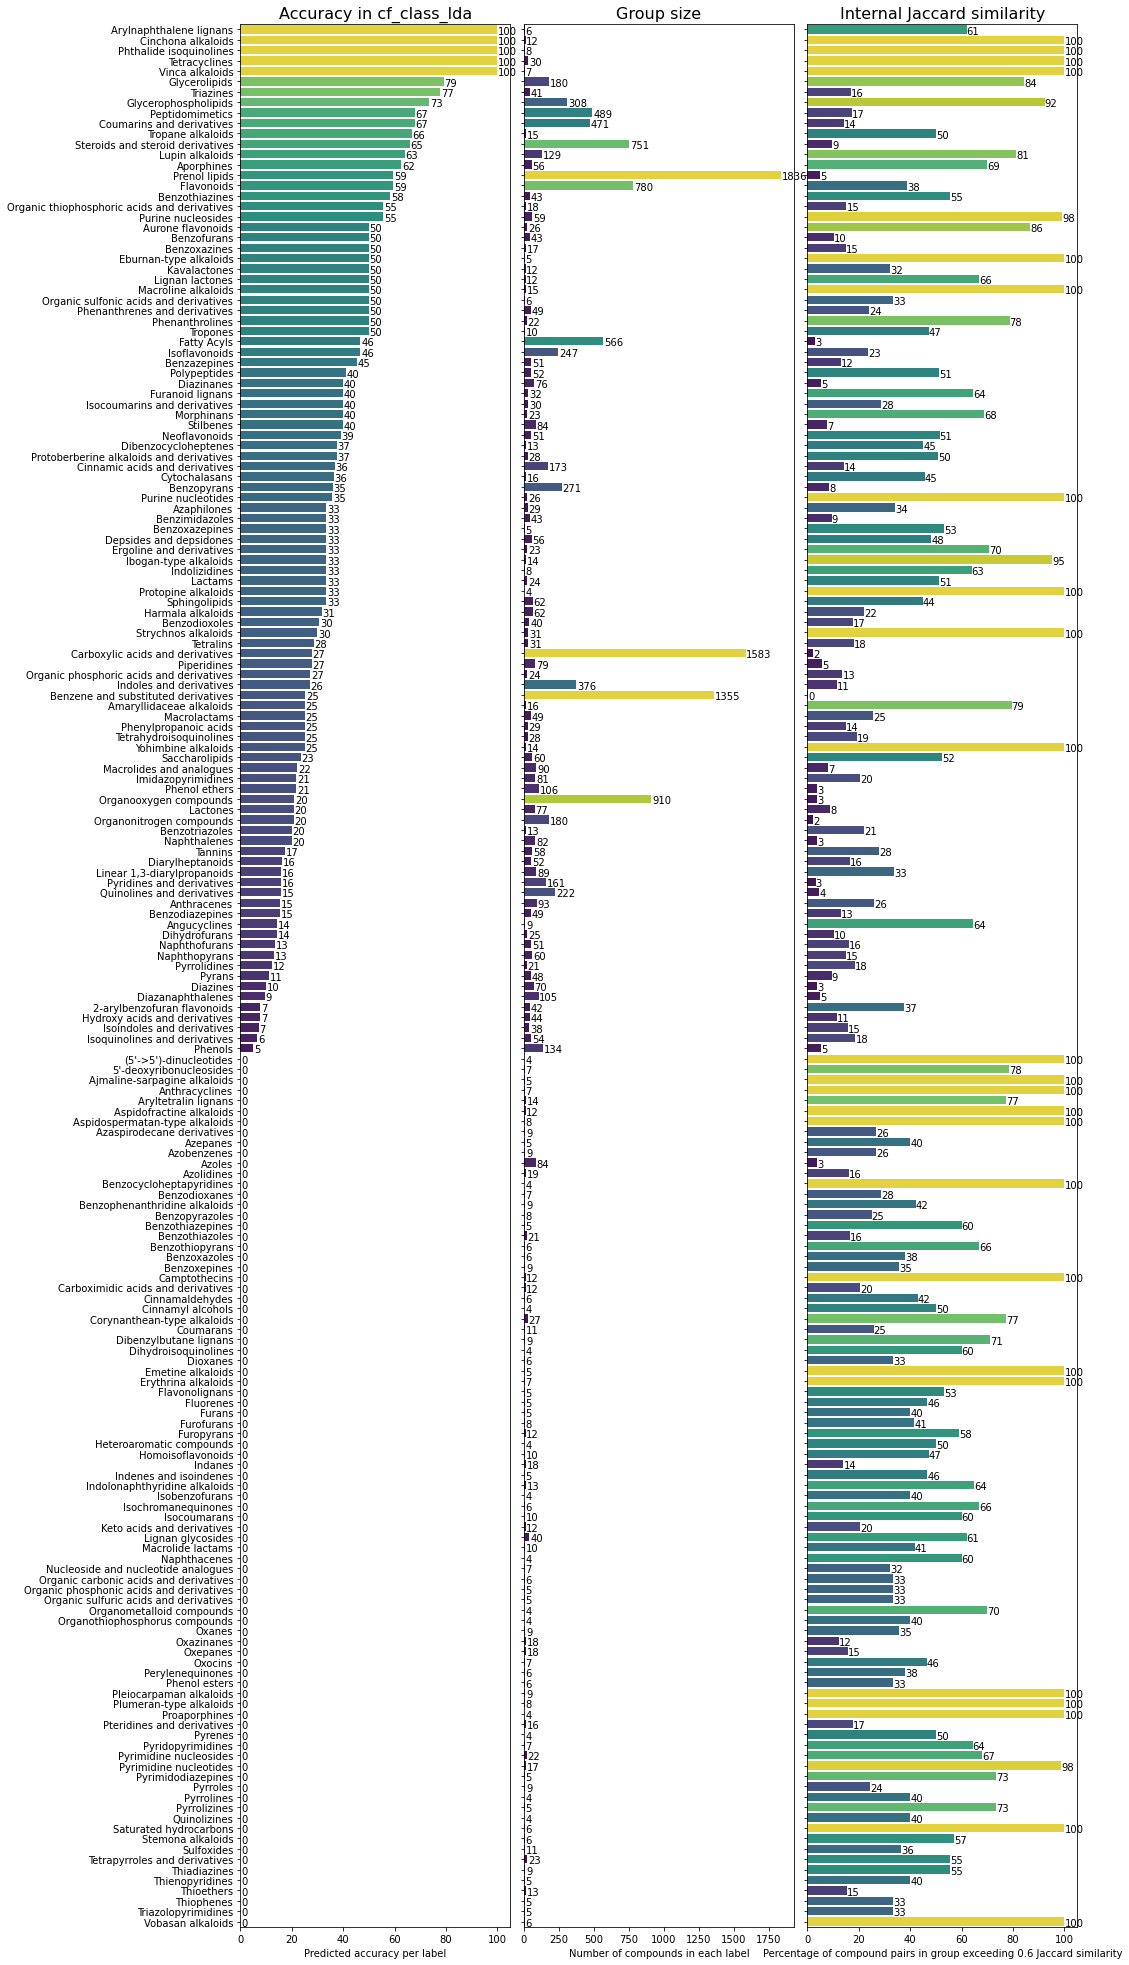

In [12]:
plot_size = (15,35)
data_type = 'cf_class_lda'
save_path = '/mnt/scratch/ding013/MS2ChemClass/barplot_accuracy_groupsize_jaccard2/'
save_path1 = '%sbarplot_accuracy_groupsize_jaccard_%s_min4.svg' % (save_path,data_type)
save_path2 = '%sbarplot_accuracy_groupsize_jaccard_%s_hierarchical_label_min4.svg' % (save_path,data_type)
label_orderedby_accuracy,accuracy_desending,groupsize_orderedby_accuracy,new_jaccard_values = ordering_accuracy_groupsize_similarity(accuracy_dict, internal_class_percentile_scores)
making_three_barplots_in_one_figure(accuracy_desending,label_orderedby_accuracy,groupsize_orderedby_accuracy,new_jaccard_values,save_path1,data_type=data_type,plot_size=plot_size)


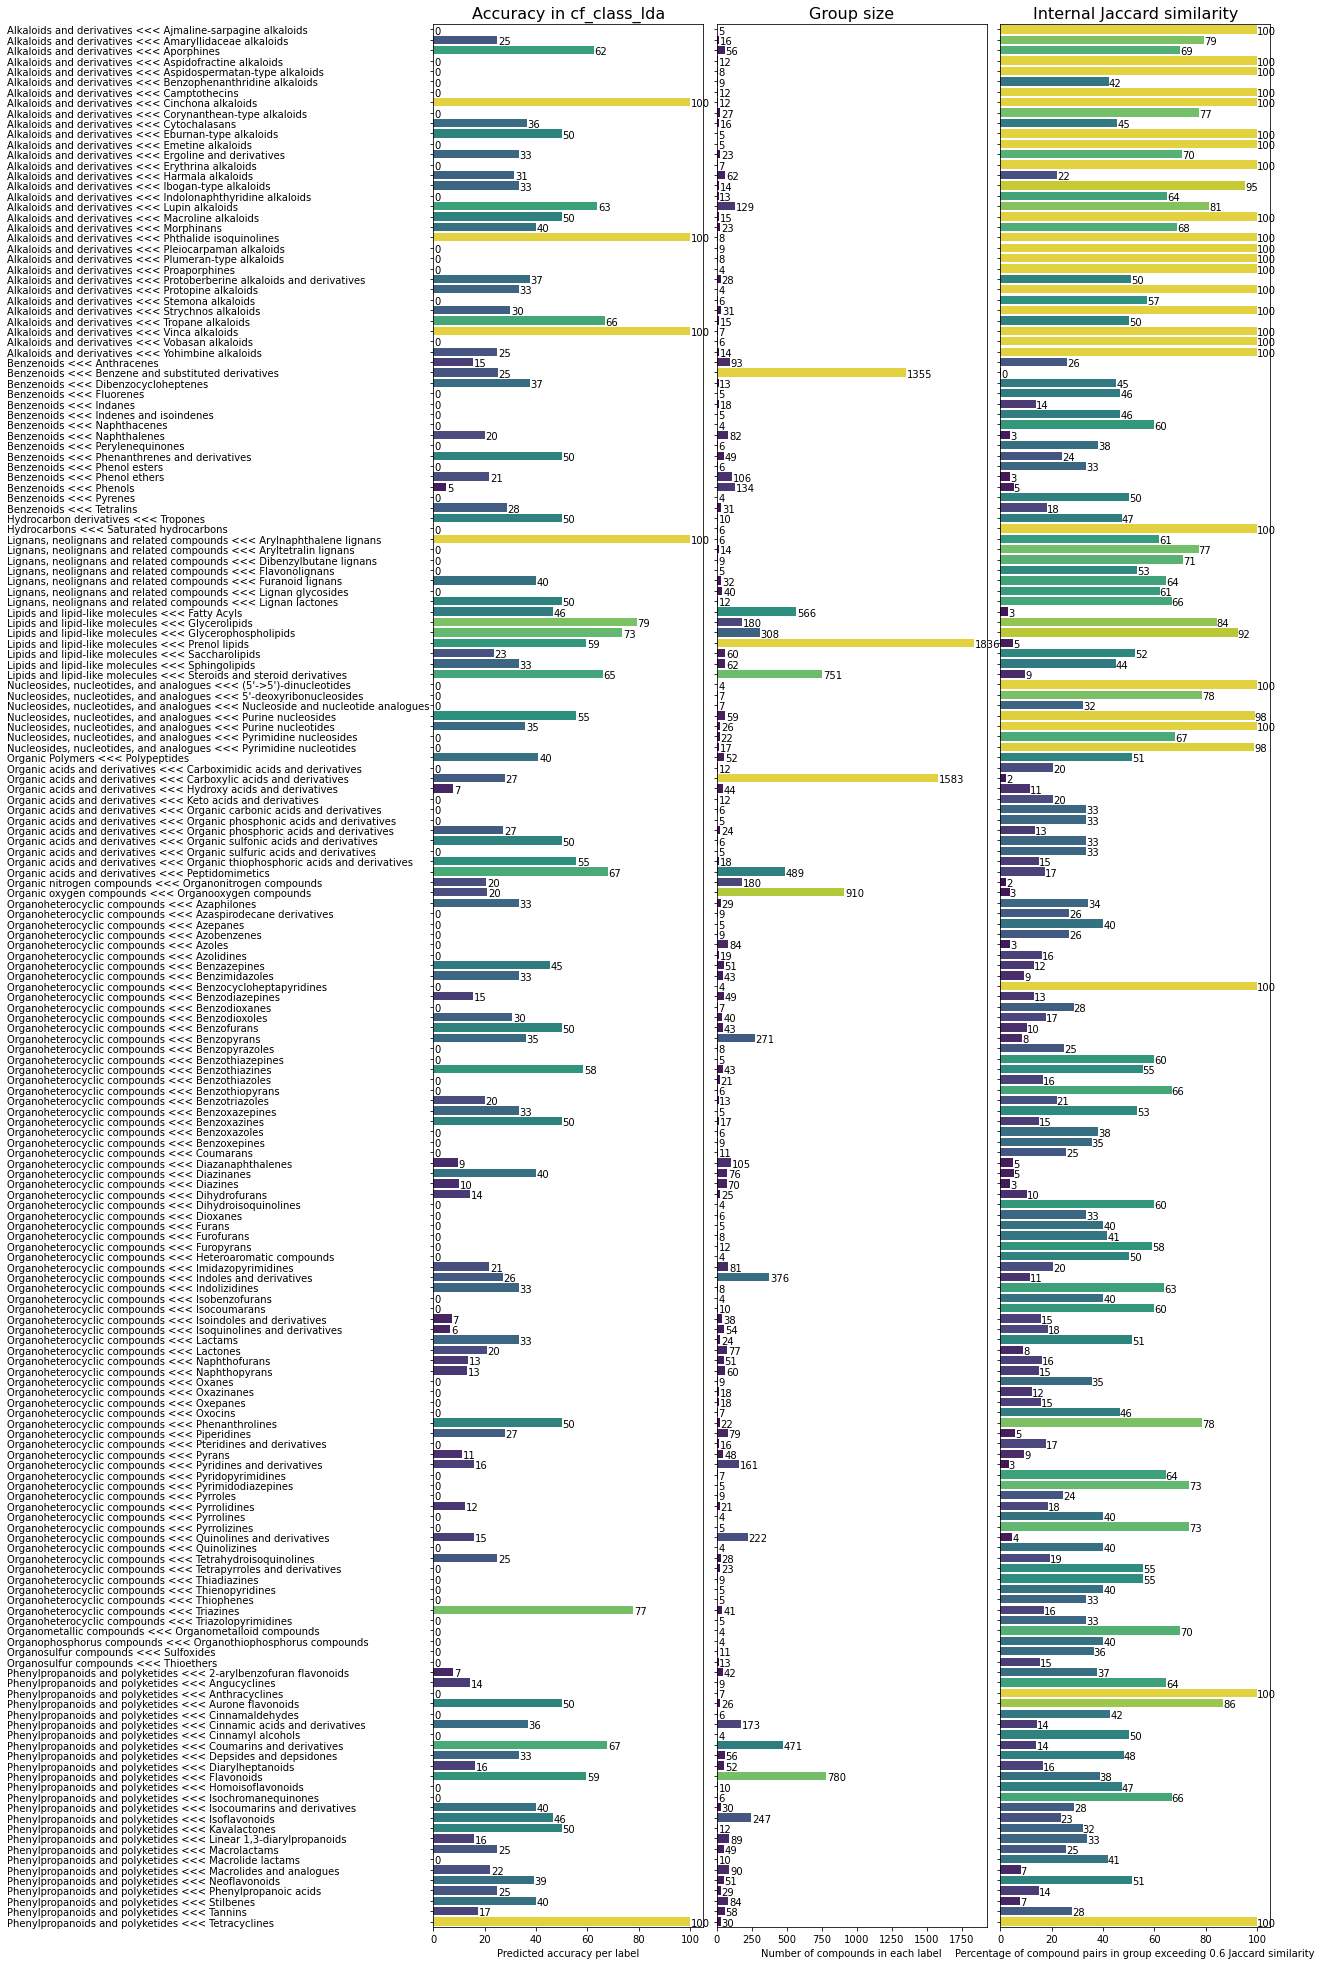

In [13]:
# barplot with hierarchical class information
plot_size=(15,35)
a = label_orderedby_accuracy
b = [hierarchical_dict[k] for k in label_orderedby_accuracy]

newlist = list(zip(range(len(a)),b,a))
ordered_newlist = sorted(newlist, key=lambda x:(x[1],x[2]))

ordered_index = [i[0] for i in ordered_newlist]
ordered_labels = [i[1]+" <<< "+i[2] for i in ordered_newlist]
ordered_accuracy = [accuracy_desending[i] for i in ordered_index]
ordered_groupsize = [groupsize_orderedby_accuracy[i] for i in ordered_index]
ordered_jaccard = [new_jaccard_values[i] for i in ordered_index]
#print(ordered_labels)

making_three_barplots_in_one_figure(ordered_accuracy,ordered_labels,ordered_groupsize,ordered_jaccard,save_path2,data_type=data_type,plot_size=plot_size, left_align=True)

#### ClassyFire Class RandomForest

In [14]:
# Load the accuracy data
with open('/mnt/scratch/ding013/MS2ChemClass/accuracy_per_label2/accuracy_per_label_cf_class_randomforest_min4.pickle', 'rb') as f:
    accuracy_dict = pickle.load(f)

183 groups involved.


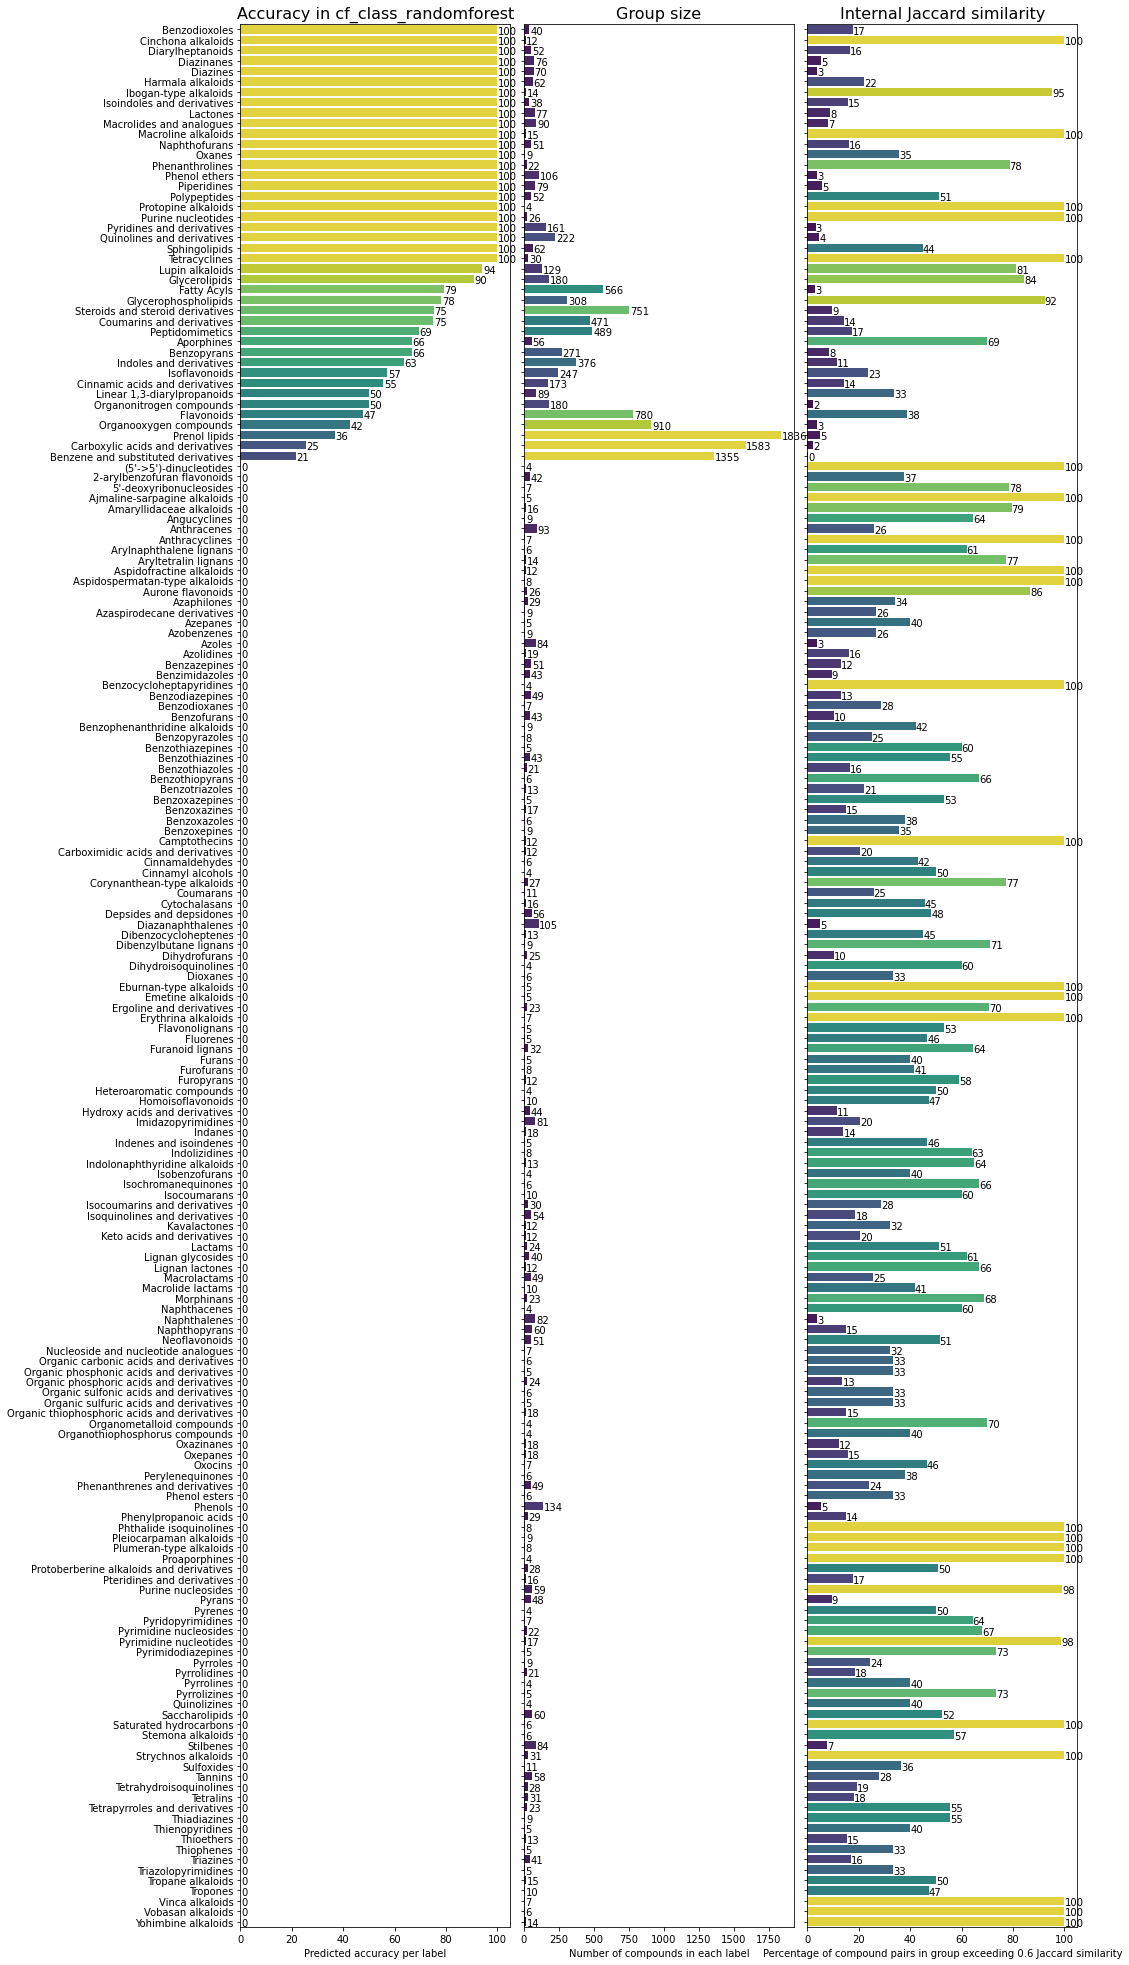

In [15]:
plot_size = (15,35)
data_type = 'cf_class_randomforest'
save_path = '/mnt/scratch/ding013/MS2ChemClass/barplot_accuracy_groupsize_jaccard2/'
save_path1 = '%sbarplot_accuracy_groupsize_jaccard_%s_min4.svg' % (save_path,data_type)
save_path2 = '%sbarplot_accuracy_groupsize_jaccard_%s_hierarchical_label_min4.svg' % (save_path,data_type)
label_orderedby_accuracy,accuracy_desending,groupsize_orderedby_accuracy,new_jaccard_values = ordering_accuracy_groupsize_similarity(accuracy_dict, internal_class_percentile_scores)
making_three_barplots_in_one_figure(accuracy_desending,label_orderedby_accuracy,groupsize_orderedby_accuracy,new_jaccard_values,save_path1,data_type=data_type,plot_size=plot_size)


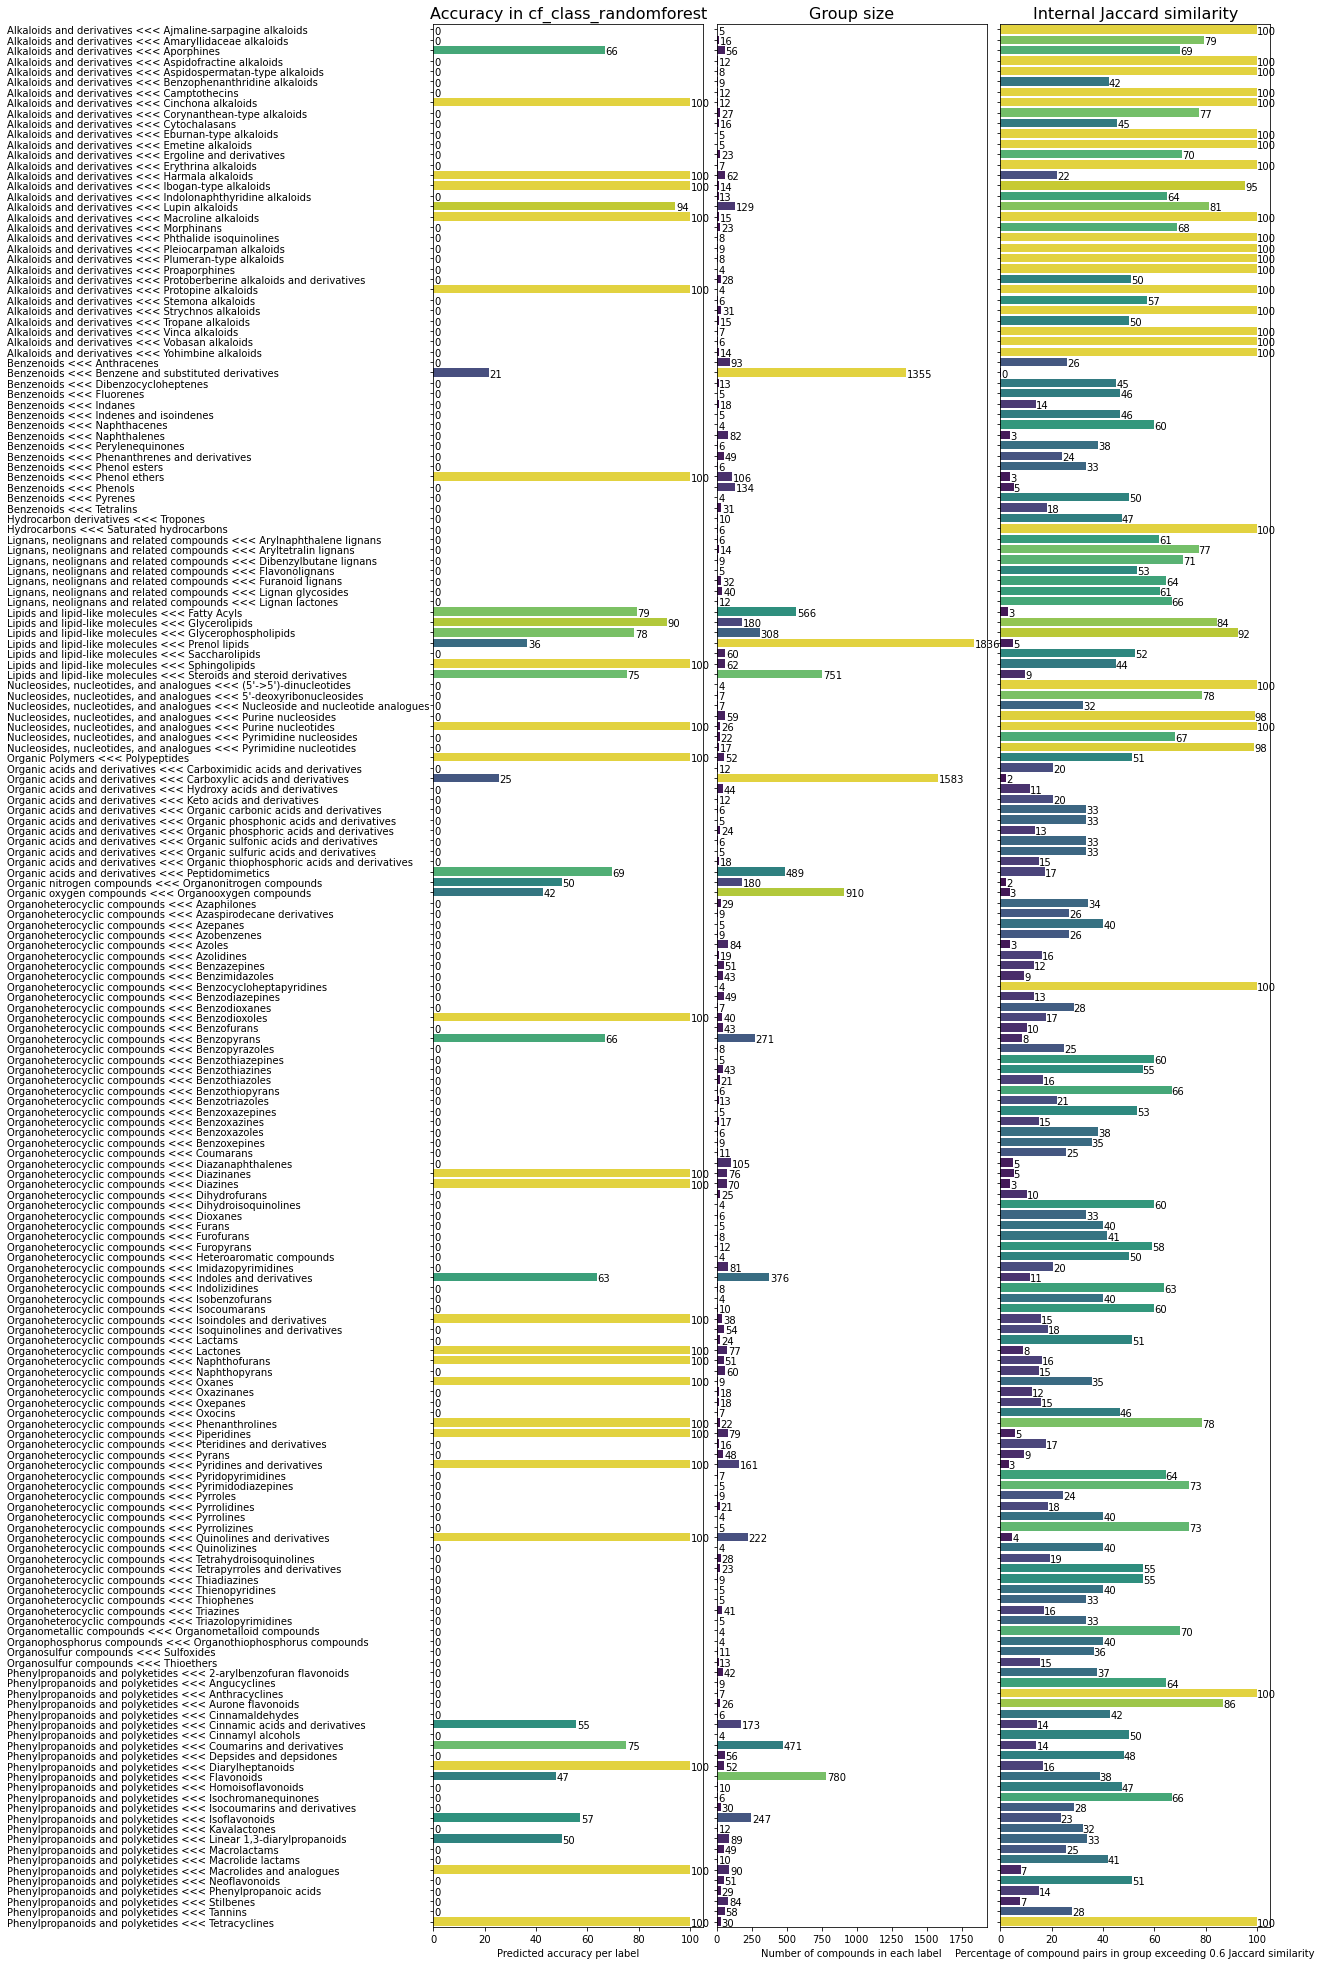

In [16]:
# barplot with hierarchical class information
#hierarchical_labels = [(hierarchical_dict[v].ljust(30)+' <<< '+v.ljust(30)) for v in label_orderedby_accuracy]
a = label_orderedby_accuracy
b = [hierarchical_dict[k] for k in label_orderedby_accuracy]
#c = [hierarchical_dict[k][1] for k in label_orderedby_accuracy]

newlist = list(zip(range(len(a)),b,a))
ordered_newlist = sorted(newlist, key=lambda x:(x[1],x[2]))

ordered_index = [i[0] for i in ordered_newlist]
ordered_labels = [i[1]+" <<< "+i[2] for i in ordered_newlist]
ordered_accuracy = [accuracy_desending[i] for i in ordered_index]
ordered_groupsize = [groupsize_orderedby_accuracy[i] for i in ordered_index]
ordered_jaccard = [new_jaccard_values[i] for i in ordered_index]
#print(ordered_labels)

making_three_barplots_in_one_figure(ordered_accuracy,ordered_labels,ordered_groupsize,ordered_jaccard,save_path2,data_type=data_type,plot_size=plot_size, left_align=True)

## ClassyFire subclasses 

In [17]:
# Get Jaccard similarities
classes, jaccard_class = jaccard_similarity_for_groups(metadata_df = spectrum_metadata.iloc[unique_inchi], var="cf_subclass", 
                                                                    spectra = inchi_spectra, min_class_size=4)
# Which percentage of spectrum pairs has a similarity higher than the threshold value of 0.6?
internal_class_percentile_scores = 100-pd.Series([percentileofscore(group, 0.6, kind = "rank") for group in jaccard_class], index = classes.index).sort_values()

288 classes exceed minimum class size


In [18]:
# Load the class belonging dict
with open('/mnt/scratch/ding013/MS2ChemClass/embedding_arrays_for_classification/cf_subclass_belong.pickle', 'rb') as f:
    hierarchical_dict = pickle.load(f)

#### ClassyFire Sublass LDA

In [19]:
# Load the accuracy data
with open('/mnt/scratch/ding013/MS2ChemClass/accuracy_per_label2/accuracy_per_label_cf_subclass_lda_min4.pickle', 'rb') as f:
    accuracy_dict = pickle.load(f)

288 groups involved.


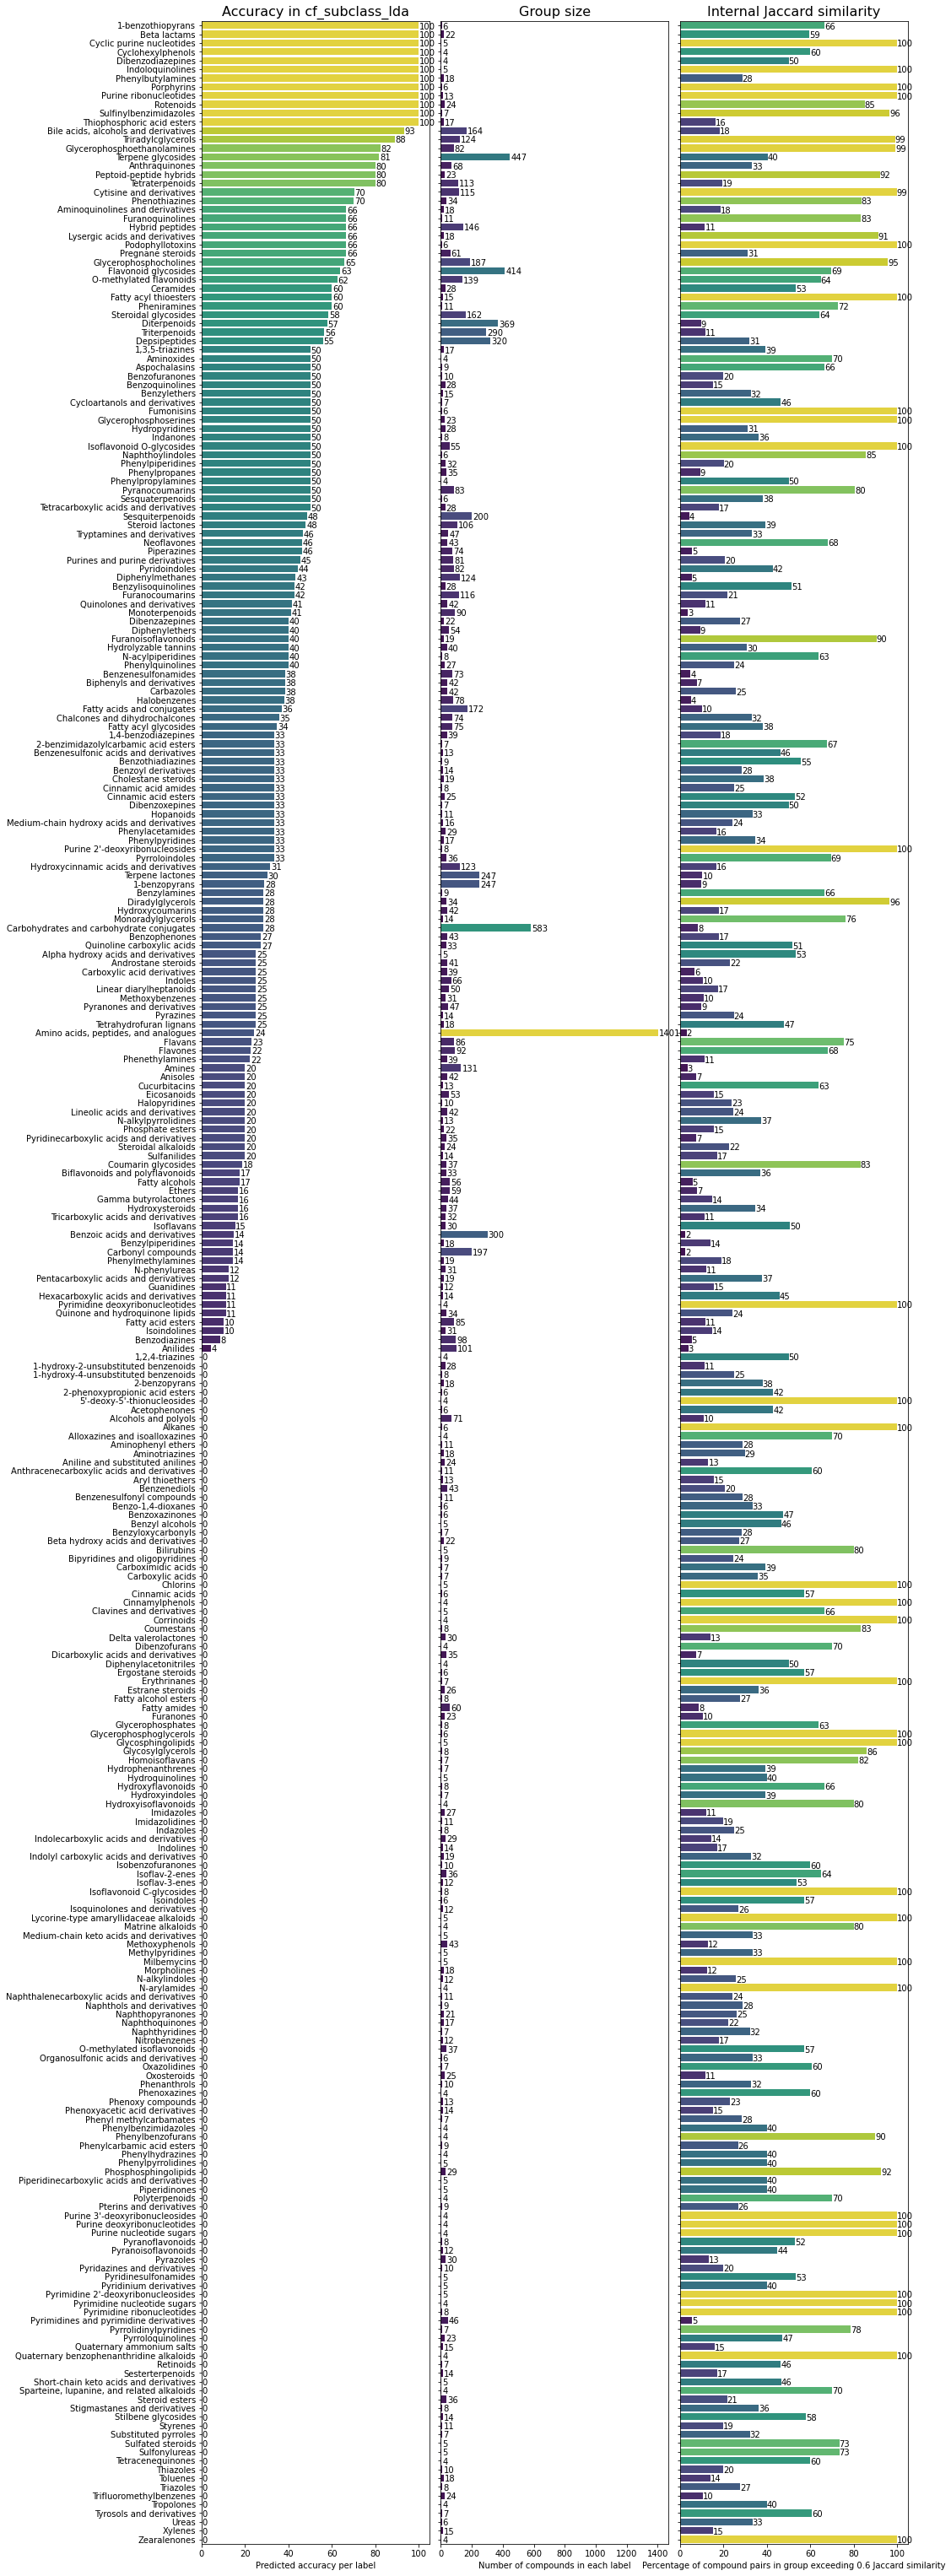

In [20]:
plot_size = (15,55)
data_type = 'cf_subclass_lda'
save_path = '/mnt/scratch/ding013/MS2ChemClass/barplot_accuracy_groupsize_jaccard2/'
save_path1 = '%sbarplot_accuracy_groupsize_jaccard_%s_min4.svg' % (save_path,data_type)
save_path2 = '%sbarplot_accuracy_groupsize_jaccard_%s_hierarchical_label_min4.svg' % (save_path,data_type)
label_orderedby_accuracy,accuracy_desending,groupsize_orderedby_accuracy,new_jaccard_values = ordering_accuracy_groupsize_similarity(accuracy_dict, internal_class_percentile_scores)
making_three_barplots_in_one_figure(accuracy_desending,label_orderedby_accuracy,groupsize_orderedby_accuracy,new_jaccard_values,save_path1,data_type=data_type,plot_size=plot_size)


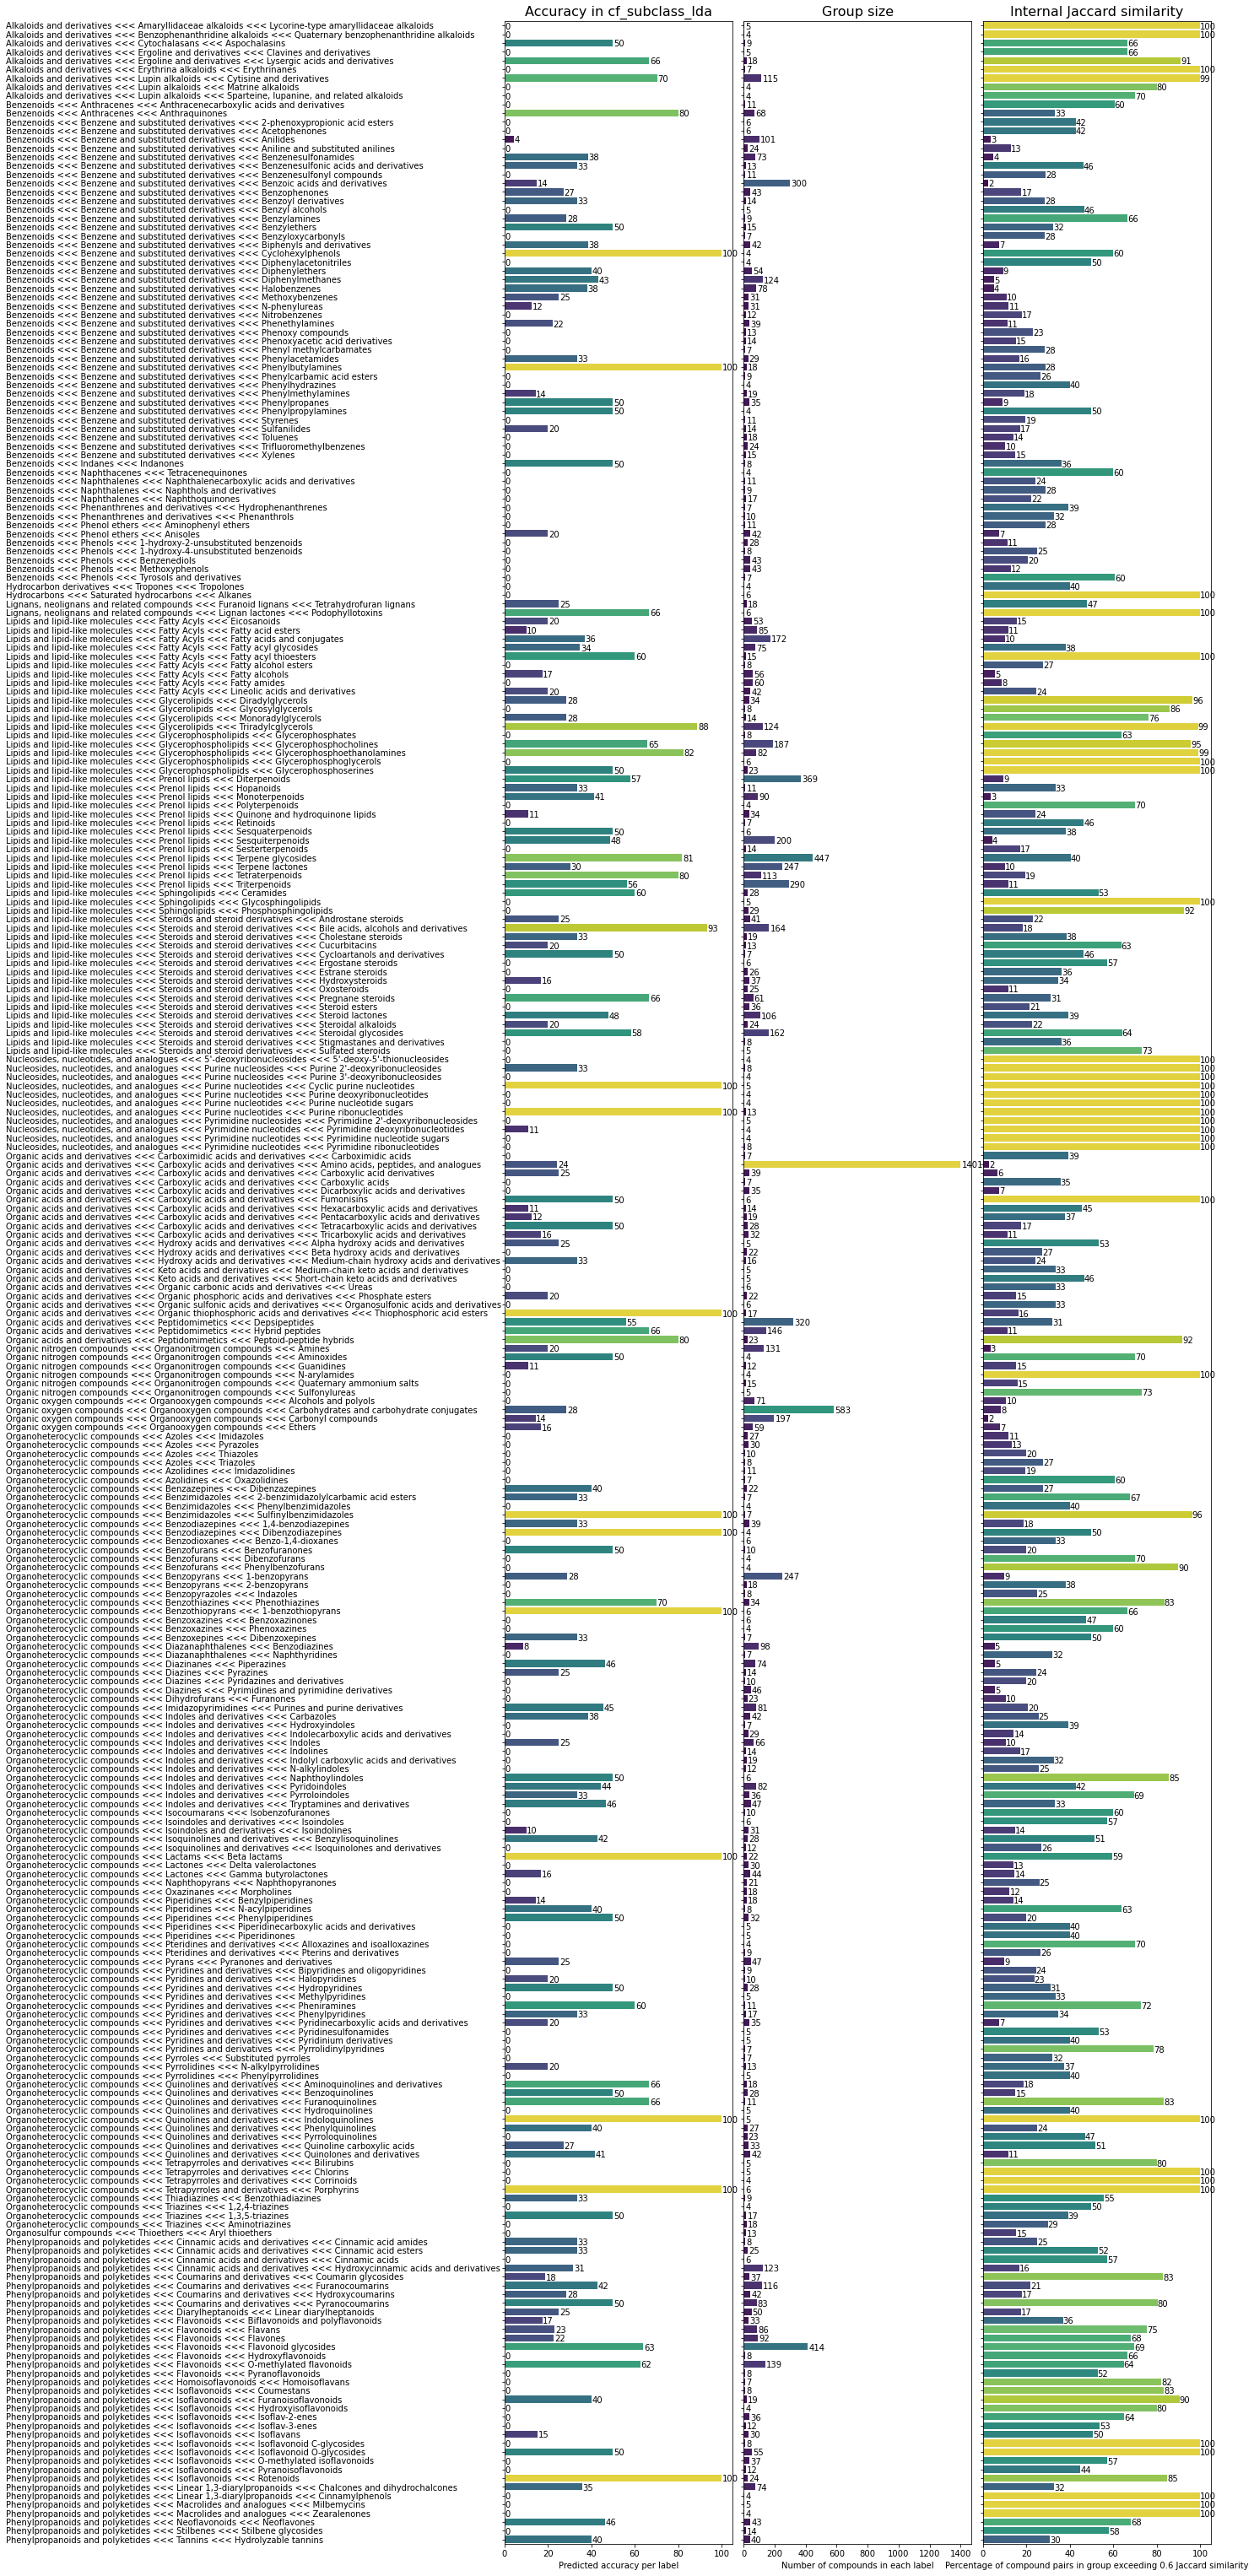

In [21]:
# barplot with hierarchical class information
#hierarchical_labels = [(hierarchical_dict[v].ljust(30)+' <<< '+v.ljust(30)) for v in label_orderedby_accuracy]
a = label_orderedby_accuracy
b = [hierarchical_dict[k][0] for k in label_orderedby_accuracy]
c = [hierarchical_dict[k][1] for k in label_orderedby_accuracy]

newlist = list(zip(range(len(a)),c,b,a))
ordered_newlist = sorted(newlist, key=lambda x:(x[1],x[2],x[3]))

ordered_index = [i[0] for i in ordered_newlist]
ordered_labels = [i[1]+" <<< "+i[2]+" <<< "+i[3] for i in ordered_newlist]
ordered_accuracy = [accuracy_desending[i] for i in ordered_index]
ordered_groupsize = [groupsize_orderedby_accuracy[i] for i in ordered_index]
ordered_jaccard = [new_jaccard_values[i] for i in ordered_index]
#print(ordered_labels)

making_three_barplots_in_one_figure(ordered_accuracy,ordered_labels,ordered_groupsize,ordered_jaccard,save_path2,data_type=data_type,plot_size=plot_size, left_align=True)

#### ClassyFire Subclass RandomForest

In [22]:
# Load the accuracy data
with open('/mnt/scratch/ding013/MS2ChemClass/accuracy_per_label2/accuracy_per_label_cf_subclass_randomforest_min4.pickle', 'rb') as f:
    accuracy_dict = pickle.load(f)

288 groups involved.


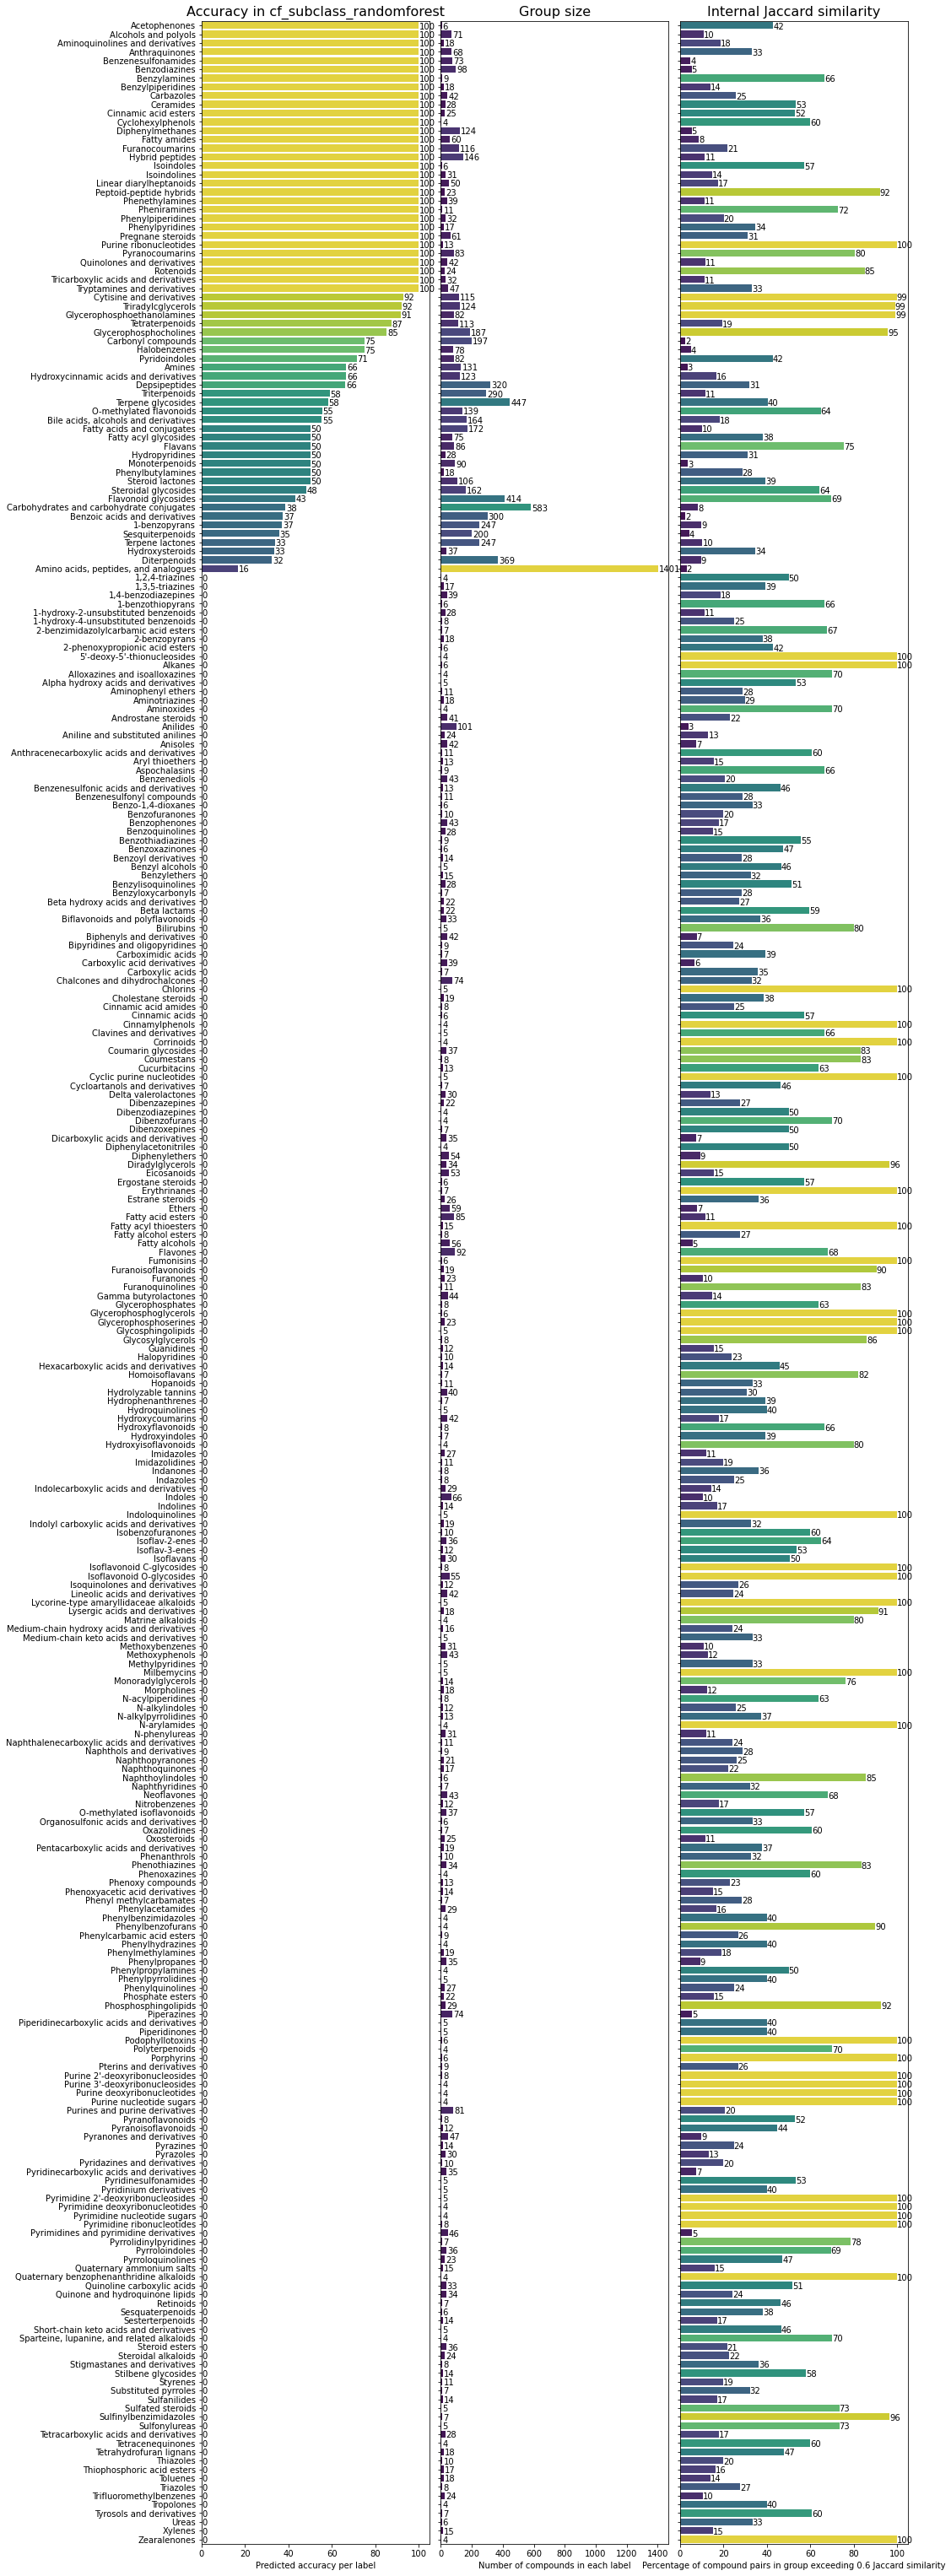

In [23]:
plot_size = (15,55)
data_type = 'cf_subclass_randomforest'
save_path = '/mnt/scratch/ding013/MS2ChemClass/barplot_accuracy_groupsize_jaccard2/'
save_path1 = '%sbarplot_accuracy_groupsize_jaccard_%s_min4.svg' % (save_path,data_type)
save_path2 = '%sbarplot_accuracy_groupsize_jaccard_%s_hierarchical_label_min4.svg' % (save_path,data_type)
label_orderedby_accuracy,accuracy_desending,groupsize_orderedby_accuracy,new_jaccard_values = ordering_accuracy_groupsize_similarity(accuracy_dict, internal_class_percentile_scores)
making_three_barplots_in_one_figure(accuracy_desending,label_orderedby_accuracy,groupsize_orderedby_accuracy,new_jaccard_values,save_path1,data_type=data_type,plot_size=plot_size)
hierarchical_labels = [(hierarchical_dict[v][1].ljust(30)+' <<< '+hierarchical_dict[v][0].ljust(30)+' <<< '+v.ljust(30)) for v in label_orderedby_accuracy]


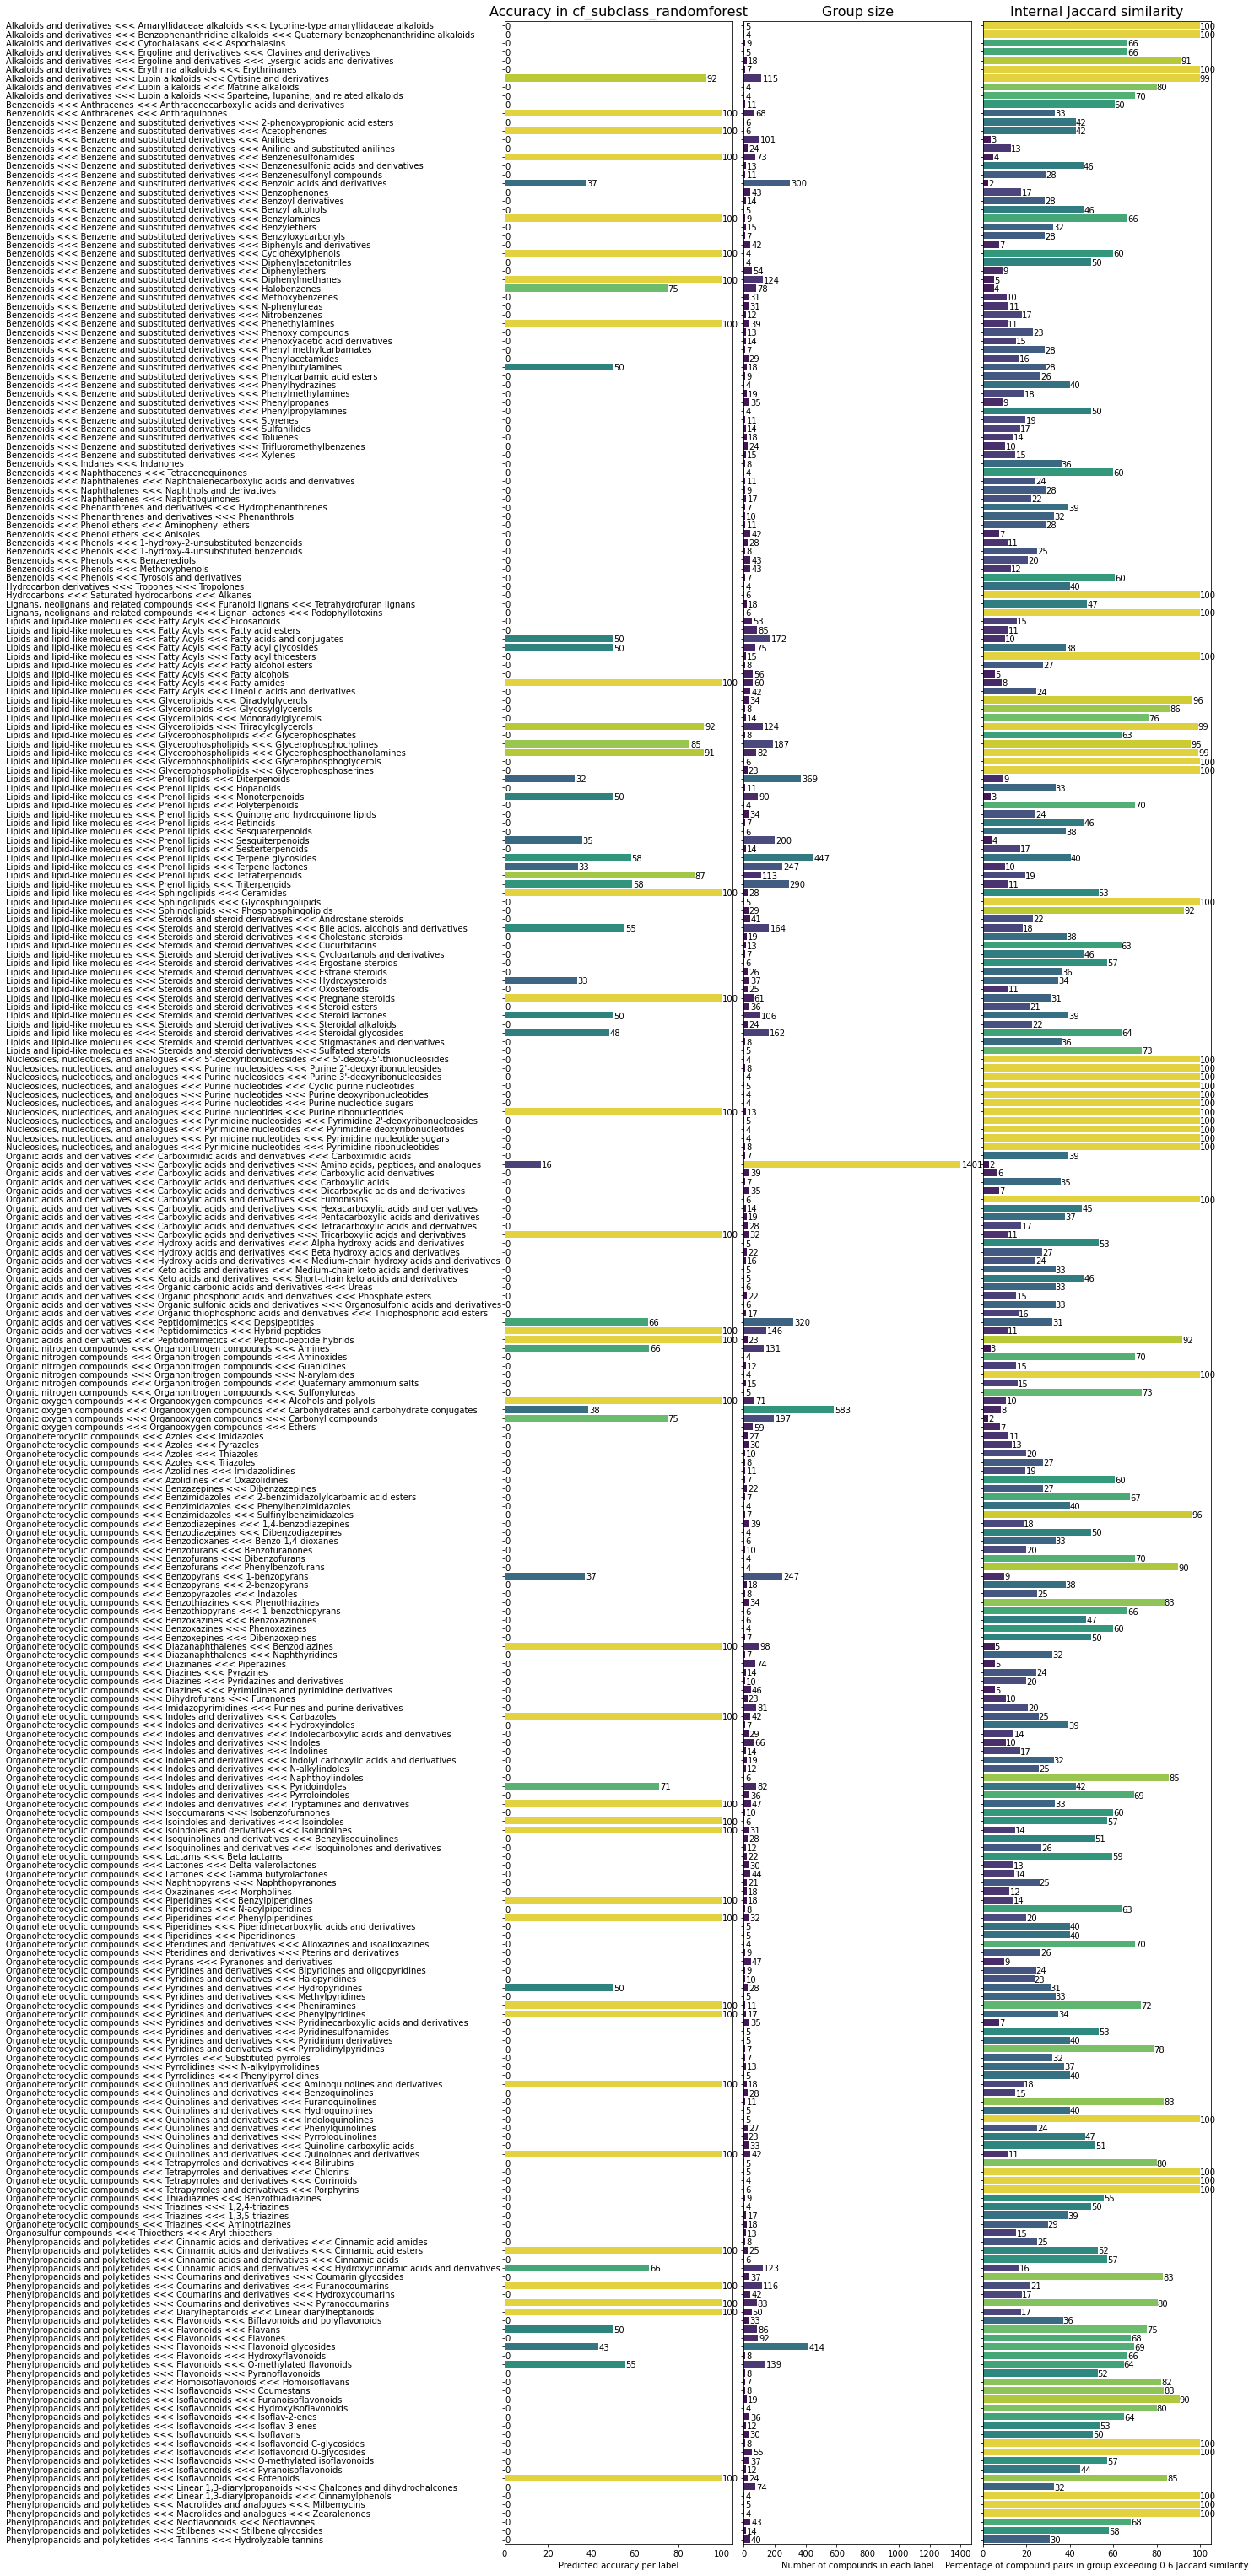

In [24]:
# barplot with hierarchical class information

a = label_orderedby_accuracy
b = [hierarchical_dict[k][0] for k in label_orderedby_accuracy]
c = [hierarchical_dict[k][1] for k in label_orderedby_accuracy]

newlist = list(zip(range(len(a)),c,b,a))
ordered_newlist = sorted(newlist, key=lambda x:(x[1],x[2],x[3]))

ordered_index = [i[0] for i in ordered_newlist]
ordered_labels = [i[1]+" <<< "+i[2]+" <<< "+i[3] for i in ordered_newlist]
ordered_accuracy = [accuracy_desending[i] for i in ordered_index]
ordered_groupsize = [groupsize_orderedby_accuracy[i] for i in ordered_index]
ordered_jaccard = [new_jaccard_values[i] for i in ordered_index]
#print(ordered_labels)

making_three_barplots_in_one_figure(ordered_accuracy,ordered_labels,ordered_groupsize,ordered_jaccard,save_path2,data_type=data_type,plot_size=plot_size, left_align=True)

## ClassyFire superclasses 

In [25]:
# Get Jaccard similarities
classes, jaccard_class = jaccard_similarity_for_groups(metadata_df = spectrum_metadata.iloc[unique_inchi], var="cf_superclass", 
                                                                    spectra = inchi_spectra, min_class_size=4)
# Which percentage of spectrum pairs has a similarity higher than the threshold value of 0.6?
internal_class_percentile_scores = 100-pd.Series([percentileofscore(group, 0.6, kind = "rank") for group in jaccard_class], index = classes.index).sort_values()

17 classes exceed minimum class size


#### ClassyFire Superclass LDA

In [26]:
# Load the accuracy data
with open('/mnt/scratch/ding013/MS2ChemClass/accuracy_per_label2/accuracy_per_label_cf_superclass_lda_min4.pickle', 'rb') as f:
    accuracy_dict = pickle.load(f)

17 groups involved.


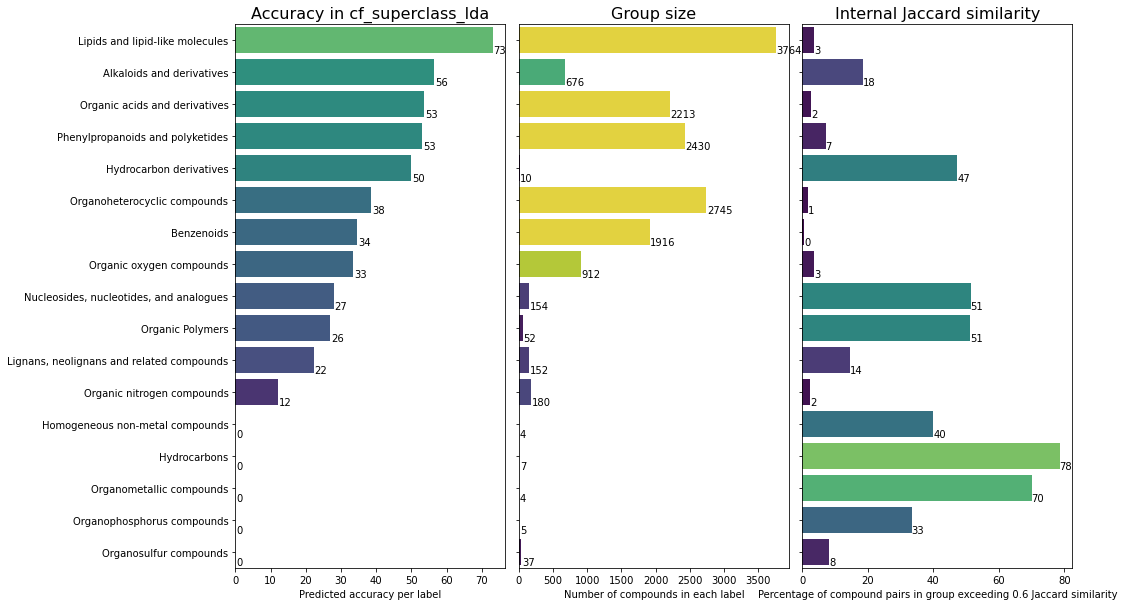

In [27]:
plot_size = (15,10)
data_type = 'cf_superclass_lda'
save_path = '/mnt/scratch/ding013/MS2ChemClass/barplot_accuracy_groupsize_jaccard2/'
save_path1 = '%sbarplot_accuracy_groupsize_jaccard_%s_min4.svg' % (save_path,data_type)
save_path2 = '%sbarplot_accuracy_groupsize_jaccard_%s_hierarchical_label_min4.svg' % (save_path,data_type)
label_orderedby_accuracy,accuracy_desending,groupsize_orderedby_accuracy,new_jaccard_values = ordering_accuracy_groupsize_similarity(accuracy_dict, internal_class_percentile_scores)
making_three_barplots_in_one_figure(accuracy_desending,label_orderedby_accuracy,groupsize_orderedby_accuracy,new_jaccard_values,save_path1,data_type=data_type,plot_size=plot_size)

#### ClassyFire Superclass RandomForest

In [28]:
# Load the accuracy data
with open('/mnt/scratch/ding013/MS2ChemClass/accuracy_per_label2/accuracy_per_label_cf_superclass_randomforest_min4.pickle', 'rb') as f:
    accuracy_dict = pickle.load(f)

17 groups involved.


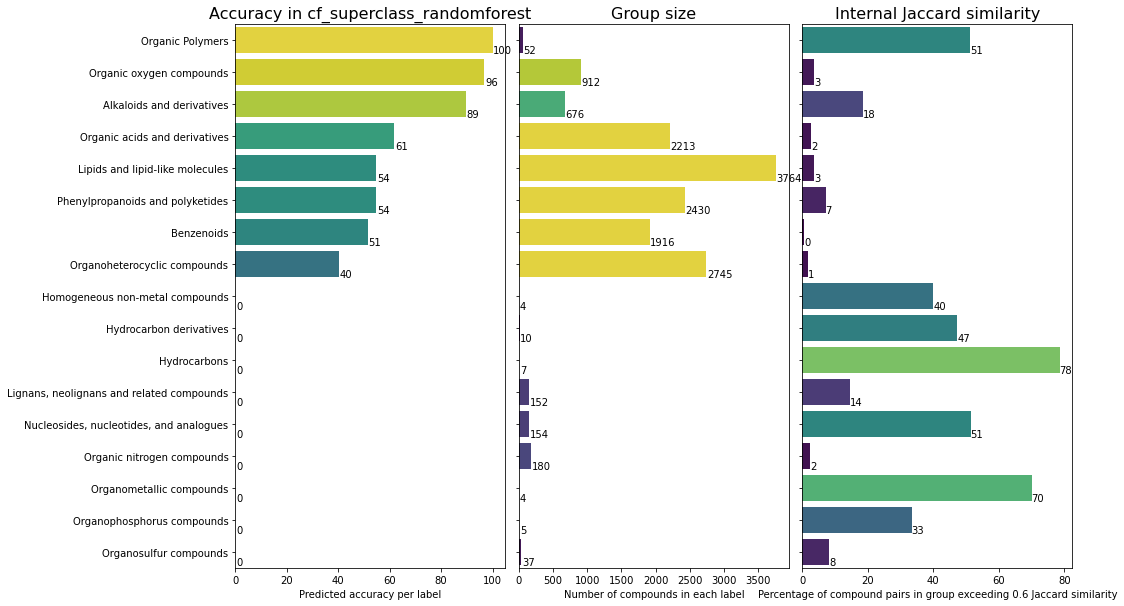

In [29]:
plot_size = (15,10)
data_type = 'cf_superclass_randomforest'
save_path = '/mnt/scratch/ding013/MS2ChemClass/barplot_accuracy_groupsize_jaccard2/'
save_path1 = '%sbarplot_accuracy_groupsize_jaccard_%s_min4.svg' % (save_path,data_type)
save_path2 = '%sbarplot_accuracy_groupsize_jaccard_%s_hierarchical_label_min4.svg' % (save_path,data_type)
label_orderedby_accuracy,accuracy_desending,groupsize_orderedby_accuracy,new_jaccard_values = ordering_accuracy_groupsize_similarity(accuracy_dict, internal_class_percentile_scores)
making_three_barplots_in_one_figure(accuracy_desending,label_orderedby_accuracy,groupsize_orderedby_accuracy,new_jaccard_values,save_path1,data_type=data_type,plot_size=plot_size)
